In [52]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mutual_info_score, make_scorer, fbeta_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

**Data preparation and cleaning**

In [53]:
# loading the dataset
file = 'data/raw_data.csv'
df = pd.read_csv(file)

df.shape

(255347, 18)

In [54]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [55]:
df.head().T

,0,1,2,3,4
LoanID,I38PQUQS96,HPSK72WA7R,C1OZ6DPJ8Y,V2KKSFM3UN,EY08JDHTZP
Age,56,69,46,32,60
Income,85994,50432,84208,31713,20437
LoanAmount,50587,124440,129188,44799,9139
CreditScore,520,458,451,743,633
MonthsEmployed,80,15,26,0,8
NumCreditLines,4,1,3,3,4
InterestRate,15.23,4.81,21.17,7.07,6.51
LoanTerm,36,60,24,24,48
DTIRatio,0.44,0.68,0.31,0.23,0.73


In [56]:
df.dtypes

LoanID             object
Age                 int64
Income              int64
LoanAmount          int64
CreditScore         int64
MonthsEmployed      int64
NumCreditLines      int64
InterestRate      float64
LoanTerm            int64
DTIRatio          float64
Education          object
EmploymentType     object
MaritalStatus      object
HasMortgage        object
HasDependents      object
LoanPurpose        object
HasCoSigner        object
Default             int64
dtype: object

In [57]:
# checking for missing values
df.isnull().sum() # no missing values

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [58]:
# checking for duplicate entries
df.duplicated().sum() # no duplicated entries

np.int64(0)

In [59]:
# removing the 'LoanID' column, as this is not needed
del df['LoanID']

In [60]:
# formatting column names
column_name_map = {
    "Age": "age",
    "Income": "income",
    "LoanAmount": "loan_amount",
    "CreditScore": "credit_score",
    "MonthsEmployed": "months_employed",
    "NumCreditLines": "num_credit_lines",
    "InterestRate": "interest_rate",
    "LoanTerm": "loan_term",
    "DTIRatio": "dti_ratio",
    "Education": 'education',
    "EmploymentType": "employment_type",
    "MaritalStatus": "marital_status",
    "HasMortgage": "has_mortgage",
    "HasDependents": "has_dependents",
    "LoanPurpose": "loan_purpose",
    "HasCoSigner": "has_cosigner",
    "Default": "default"
}

df = df.rename(columns=column_name_map)

df.head().T

,0,1,2,3,4
age,56,69,46,32,60
income,85994,50432,84208,31713,20437
loan_amount,50587,124440,129188,44799,9139
credit_score,520,458,451,743,633
months_employed,80,15,26,0,8
num_credit_lines,4,1,3,3,4
interest_rate,15.23,4.81,21.17,7.07,6.51
loan_term,36,60,24,24,48
dti_ratio,0.44,0.68,0.31,0.23,0.73
education,Bachelor's,Master's,Master's,High School,Bachelor's


In [61]:
# obtaining all entries of all categorical columns, in preparation for data cleaning
categorical = ["education", "employment_type", "marital_status", "has_mortgage", "has_dependents", "loan_purpose", "has_cosigner"]

for col in categorical:
    print(col)
    print(df[col].unique())
    print("############################################")

education
["Bachelor's" "Master's" 'High School' 'PhD']
############################################
employment_type
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
############################################
marital_status
['Divorced' 'Married' 'Single']
############################################
has_mortgage
['Yes' 'No']
############################################
has_dependents
['Yes' 'No']
############################################
loan_purpose
['Other' 'Auto' 'Business' 'Home' 'Education']
############################################
has_cosigner
['Yes' 'No']
############################################


In [62]:
# formatting categorical column entries
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_').str.replace("'", '').str.replace('-', '_')

for col in categorical:
    print(col)
    print(df[col].unique())
    print("############################################")

education
['bachelors' 'masters' 'high_school' 'phd']
############################################
employment_type
['full_time' 'unemployed' 'self_employed' 'part_time']
############################################
marital_status
['divorced' 'married' 'single']
############################################
has_mortgage
['yes' 'no']
############################################
has_dependents
['yes' 'no']
############################################
loan_purpose
['other' 'auto' 'business' 'home' 'education']
############################################
has_cosigner
['yes' 'no']
############################################


Splitting into training and testing datasets (80%/20%)

In [63]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=5)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Exploratory data analysis** 

- Following best practice guidelines, we exclude the testing dataset from EDA

In [64]:
# creating a copy of the full training dataset for EDA
df_eda = df_train.copy()

In [65]:
df_eda.head()

,age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,loan_term,dti_ratio,education,employment_type,marital_status,has_mortgage,has_dependents,loan_purpose,has_cosigner,default
0,46,28643,246955,360,69,1,4.83,36,0.29,bachelors,part_time,married,no,no,home,no,1
1,28,145561,154823,849,111,2,23.46,60,0.52,masters,unemployed,single,yes,no,education,no,0
2,18,49640,27228,465,105,4,18.88,24,0.72,bachelors,full_time,married,yes,yes,home,yes,0
3,68,90271,130874,786,59,3,17.73,48,0.67,high_school,self_employed,divorced,yes,no,business,no,0
4,40,31530,246394,594,89,4,14.75,36,0.28,bachelors,self_employed,single,no,yes,home,no,1


In [66]:
# value counts of the target feature, 'default'
df_eda['default'].value_counts()

default
0    180584
1     23693
Name: count, dtype: int64

In [67]:
df_eda['default'].value_counts(normalize=True)

default
0    0.884015
1    0.115985
Name: proportion, dtype: float64

In [68]:
# value counts of the categorical columns
for col in categorical:
    print(df_eda[col].value_counts())
    print(df_eda[col].value_counts(normalize=True))
    print("############################################")

education
bachelors      51301
high_school    51167
masters        50919
phd            50890
Name: count, dtype: int64
education
bachelors      0.251134
high_school    0.250479
masters        0.249264
phd            0.249123
Name: proportion, dtype: float64
############################################
employment_type
part_time        51393
unemployed       51102
self_employed    50902
full_time        50880
Name: count, dtype: int64
employment_type
part_time        0.251585
unemployed       0.250160
self_employed    0.249181
full_time        0.249074
Name: proportion, dtype: float64
############################################
marital_status
married     68440
divorced    67937
single      67900
Name: count, dtype: int64
marital_status
married     0.335035
divorced    0.332573
single      0.332392
Name: proportion, dtype: float64
############################################
has_mortgage
yes    102151
no     102126
Name: count, dtype: int64
has_mortgage
yes    0.500061
no     0.499939
N

In [69]:
# describing the numerical columns
numerical = ['age', 'income', 'loan_amount', 'credit_score', 'months_employed', 'num_credit_lines', 'interest_rate', 'loan_term', 'dti_ratio']

df_eda[numerical].describe().round(2)

,age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,loan_term,dti_ratio
count,204277.0,204277.00,204277.00,204277.0,204277.00,204277.00,204277.00,204277.00,204277.00
mean,43.5,82481.06,127566.15,574.3,59.54,2.50,13.50,36.00,0.50
std,15.0,38964.90,70800.02,158.9,34.64,1.12,6.64,16.97,0.23
min,18.0,15000.00,5000.00,300.0,0.00,1.00,2.00,12.00,0.10
25%,31.0,48786.00,66159.00,437.0,30.00,2.00,7.78,24.00,0.30
50%,43.0,82461.00,127625.00,574.0,60.00,2.00,13.46,36.00,0.50
75%,56.0,116163.00,188871.00,712.0,90.00,3.00,19.26,48.00,0.70
max,69.0,149999.00,249998.00,849.0,119.00,4.00,25.00,60.00,0.90


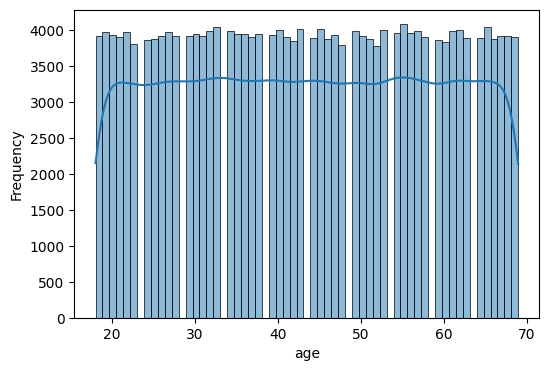

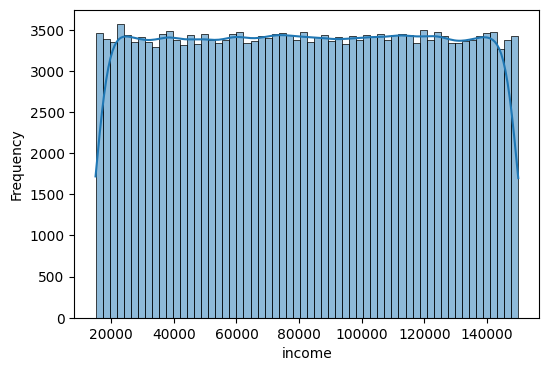

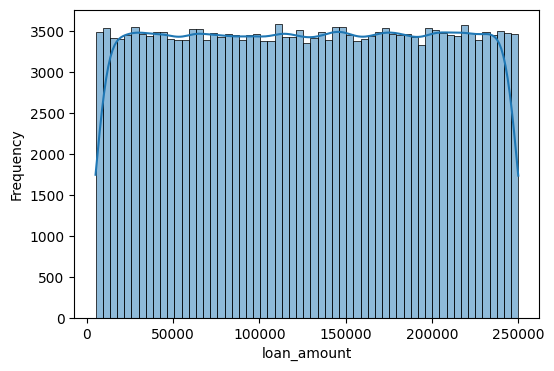

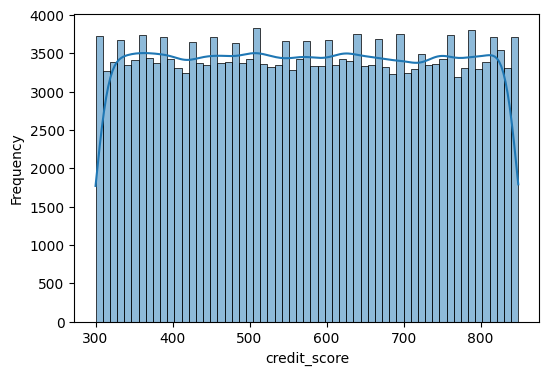

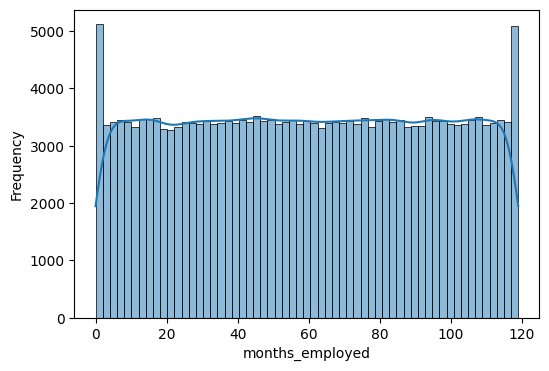

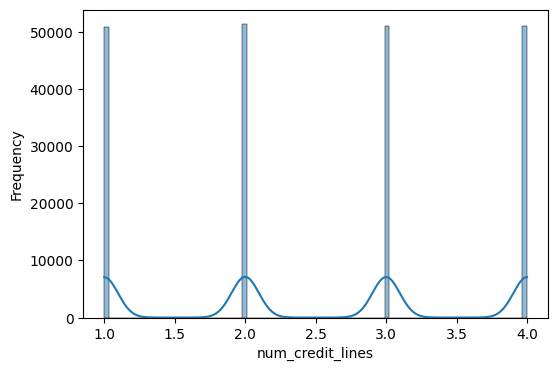

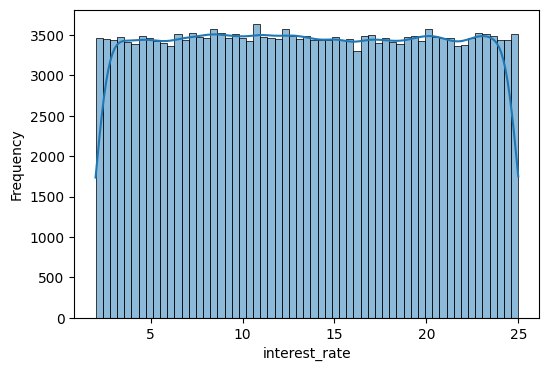

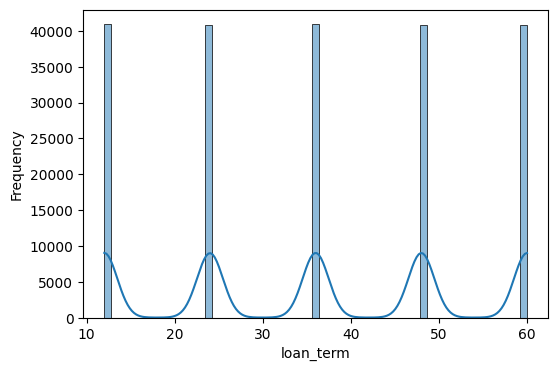

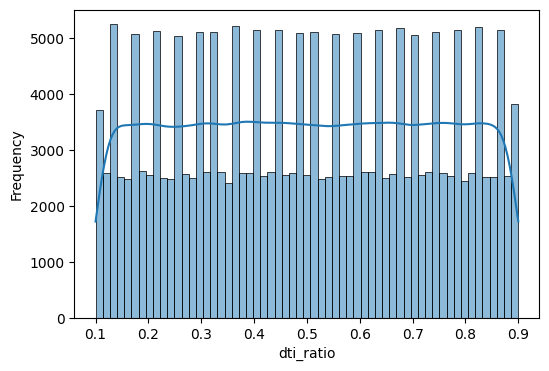

In [70]:
# plotting histograms of the numerical columns
for col in numerical:
    plt.figure(figsize=(6,4))
    sns.histplot(df_eda[col], kde=True)
    plt.ylabel('Frequency')
    plt.xlabel(col)

    plt.show()

**Feature importance**

Categorical features

In [71]:
global_mean = df_eda['default'].mean()

for col in categorical:
    df_group = df_eda.groupby(by=col).default.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
education,,,
bachelors,0.121635,0.005650,1.048717
high_school,0.128169,0.012184,1.105047
masters,0.108525,-0.007459,0.935687
phd,0.105502,-0.010483,0.909621


,mean,diff,risk
employment_type,,,
full_time,0.094615,-0.021370,0.815752
part_time,0.120075,0.004090,1.035264
self_employed,0.113728,-0.002256,0.980546
unemployed,0.135396,0.019411,1.167360


,mean,diff,risk
marital_status,,,
divorced,0.125425,0.009440,1.081393
married,0.103872,-0.012113,0.895567
single,0.118748,0.002763,1.023826


,mean,diff,risk
has_mortgage,,,
no,0.123220,0.007236,1.062385
yes,0.108751,-0.007234,0.937631


,mean,diff,risk
has_dependents,,,
no,0.127273,0.011289,1.097330
yes,0.104704,-0.011281,0.902738


,mean,diff,risk
loan_purpose,,,
auto,0.118574,0.002589,1.022324
business,0.122299,0.006314,1.054441
education,0.118587,0.002602,1.022438
home,0.102252,-0.013733,0.881599
other,0.118276,0.002291,1.019754


,mean,diff,risk
has_cosigner,,,
no,0.128346,0.012362,1.106581
yes,0.103663,-0.012322,0.893762


In [72]:
# mutual information between each of the categorical columns and the target feature
def calculate_mi(series):
    return mutual_info_score(series, df_eda['default'])

df_mi = df_eda[categorical].apply(calculate_mi).sort_values(ascending=False).to_frame(name='mutual_information')
display(df_mi)

,mutual_information
employment_type,0.001053
has_cosigner,0.000744
has_dependents,0.000622
education,0.000421
marital_status,0.000401
has_mortgage,0.000255
loan_purpose,0.000248


Numerical features

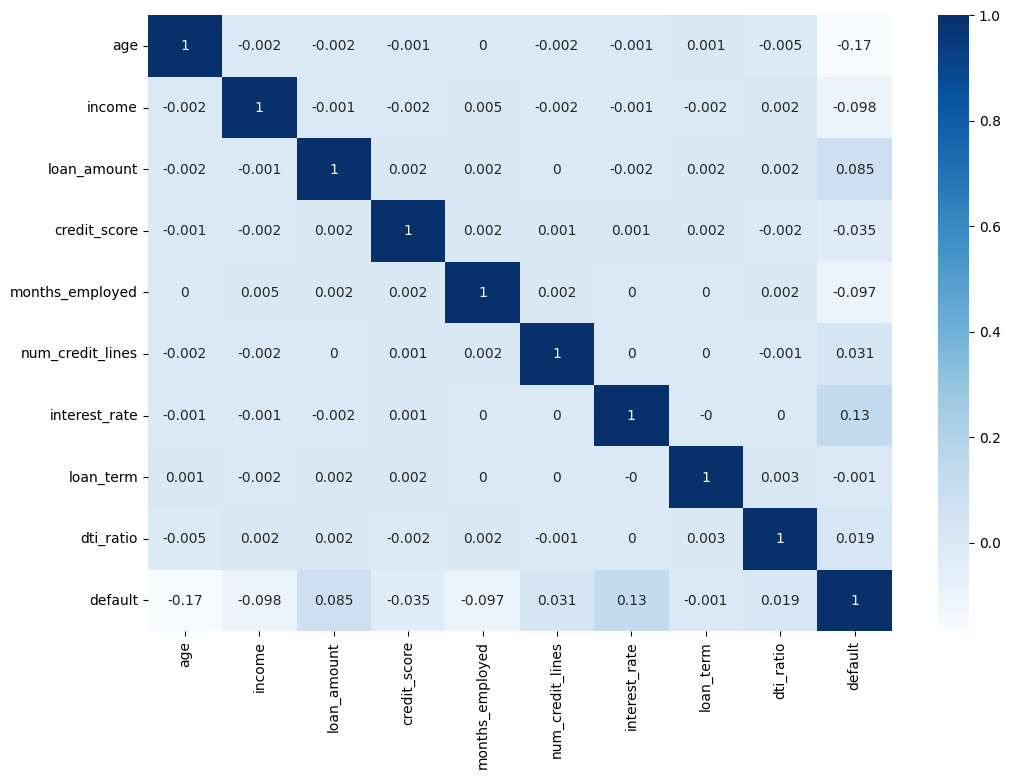

In [73]:
# correlation heatmap for numerical features
numerical.append('default')

plt.figure(figsize=(12,8))
sns.heatmap(df_eda[numerical].corr().round(3), annot=True, cmap="Blues")
plt.show()

In [74]:
# correlations with target feature
df_eda[numerical].corr()['default'].sort_values(ascending=False)

default             1.000000
interest_rate       0.130688
loan_amount         0.085486
num_credit_lines    0.031094
dti_ratio           0.018776
loan_term          -0.000686
credit_score       -0.034644
months_employed    -0.097462
income             -0.097841
age                -0.168305
Name: default, dtype: float64

**Feature selection**

We will omit the following features:

- 'loan_term' - minimal absolute correlation with the target variable
- all categorical features - minimal mutual information with the target variable

In [75]:
for col in ['loan_term', 'education', 'employment_type', 'marital_status', 'has_mortgage', 'has_dependents', 'loan_purpose', 'has_cosigner']:
    del df_train[col]
    del df_test[col]

In [76]:
# feature names
features = ['age', 'income', 'loan_amount', 'credit_score', 'months_employed', 'num_credit_lines', 'interest_rate', 'dti_ratio']

Training a baseline logistic regression model

In [77]:
# performing a 75%/25% testing/validation split for training and evaluating the baseline model
df_train_baseline, df_val_baseline = train_test_split(df_train, test_size=0.2, random_state=5)

In [78]:
# splitting off the target feature
y_train_baseline = df_train_baseline['default'].values
y_val_baseline = df_val_baseline['default'].values

del df_train_baseline['default']
del df_val_baseline['default']

In [79]:
# preprocessor for our models
preprocess = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), features),
    ]
)

In [80]:
# model pipeline
baseline_model = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        random_state=7
    ))
])

In [81]:
# training the baseline model
baseline_model.fit(df_train_baseline, y_train_baseline)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard_scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [82]:
# obtaining baseline model performance metrics
y_pred_baseline = baseline_model.predict(df_val_baseline)

print("Classification Report:")
print(classification_report(y_val_baseline, y_pred_baseline)) # this is consistent with a 'lazy' classifier predicting 'no default' for almost everyone
print("F2 score:", fbeta_score(y_true=y_val_baseline, y_pred=y_pred_baseline, beta=2, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     36153
           1       0.66      0.02      0.04      4703

    accuracy                           0.89     40856
   macro avg       0.77      0.51      0.49     40856
weighted avg       0.86      0.89      0.84     40856

F2 score: 0.028194993412384718


**Model selection**

- Model types to be considered: logistic regression, decision tree classifier, XGBoost classifier

- For each model type considered, we perform hyper-parameter tuning (using RandomizedSearchCV to save resources), utilising five-fold cross validation 

- Due to class imbalance in the target variable, together with the real-world consequence of a loanee defaulting on their loan being a significantly worse outcome for a bank than denying a loan to someone who would have been able to pay off the loan (i.e. false negatives are significantly worse than false positives), we will use the F2 score as our primary evaluation metric (twice as much weight is given to recall over precision).

In [83]:
# splitting off the target feature
y_train = df_train['default'].values
y_test = df_train['default'].values

del df_train['default']
del df_test['default']

In [84]:
df_train.head()

,age,income,loan_amount,credit_score,months_employed,num_credit_lines,interest_rate,dti_ratio
0,46,28643,246955,360,69,1,4.83,0.29
1,28,145561,154823,849,111,2,23.46,0.52
2,18,49640,27228,465,105,4,18.88,0.72
3,68,90271,130874,786,59,3,17.73,0.67
4,40,31530,246394,594,89,4,14.75,0.28


In [85]:
y_train

array([1, 0, 0, ..., 0, 0, 0], shape=(204277,))

In [86]:
# cross-validation framework - using StratifiedKFold due to class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [87]:
# scorer for model evaluation
f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

Logistic regression

In [88]:
# parameter distributions
param_dist = {
    'model__C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    'model__max_iter': [50, 100, 500, 1000, 2000],
    'model__class_weight': [None, 'balanced'],
    'model__solver': ['liblinear', 'sag']
}

In [89]:
# model pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        random_state=7
    ))
])

In [90]:
# performing a random search using cross-validation to find optimal model parameters
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    scoring=f2_scorer,
    cv=cv,
    n_iter=50,
    n_jobs=-1,
    random_state=7,
    verbose=1
)

random_search.fit(df_train, y_train)

# outputting values for best parameters
print("Best parameters:", random_search.best_params_)
print("Best mean F2 score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/georgecooper/Documents/python/ML_Zoomcamp_2025/Midterm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgecooper/Documents/python/ML_Zoomcamp_2025/Midterm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgecooper/Documents/python/ML_Zoomcamp_2025/Midterm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgecooper/Documents/python/ML_Zoomcamp_2025/Midterm/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/georgecooper/Documents/python/ML_Zoomcamp_2025/Midterm/.venv/lib/

Best parameters: {'model__solver': 'sag', 'model__max_iter': 50, 'model__class_weight': 'balanced', 'model__C': 0.001}
Best mean F2 score: 0.4714650178000629


Decision tree classifier

In [91]:
# parameter distributions
param_dist = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__class_weight': [None, 'balanced'],
    'model__max_features': ['sqrt', 'log2', None]
}

In [92]:
# model pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(
        random_state=7
    ))
])

In [93]:
# performing a random search using cross-validation to find optimal model parameters
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    scoring=f2_scorer,
    cv=cv,
    n_iter=50,
    n_jobs=-1,
    random_state=7,
    verbose=1,
)

random_search.fit(df_train, y_train)

# outputting values for best parameters
print("Best parameters:", random_search.best_params_)
print("Best mean F2 score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__min_samples_split': 5, 'model__min_samples_leaf': 8, 'model__max_features': None, 'model__max_depth': 5, 'model__criterion': 'gini', 'model__class_weight': 'balanced'}
Best mean F2 score: 0.45308242465442206


XGBoost classifier

In [94]:
# parameter distributions
param_dist = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [3, 6, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1],
    'model__scale_pos_weight': [1, 3, 5]
}

In [95]:
# model pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        random_state=7,
        objective='binary:logistic',
        eval_metric='logloss',
    ))
])

In [96]:
# performing a random search using cross-validation to find optimal model parameters
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    scoring=f2_scorer,
    cv=cv,
    n_iter=50,
    n_jobs=-1,
    random_state=7,
    verbose=1
)

random_search.fit(df_train, y_train)

# outputting values for best parameters
print("Best parameters:", random_search.best_params_)
print("Best mean F2 score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__subsample': 0.8, 'model__scale_pos_weight': 5, 'model__n_estimators': 100, 'model__min_child_weight': 5, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__colsample_bytree': 0.8}
Best mean F2 score: 0.4340687631553048


**Final model selection**

For each model type considered above, we will consider the model with the best parameters found above. We will use stratified cross-validation to compare the performance of these models, by generating more detailed classification reports for each model.

In [97]:
# defining our models, using the best parameters determined above
lr_model = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        random_state=7,
        solver='sag',
        max_iter=50,
        class_weight='balanced',
        C=0.001
    ))
])

dt_model = Pipeline([
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(
        random_state=7,
        min_samples_split=5,
        min_samples_leaf=8,
        max_features=None,
        max_depth=5,
        criterion='gini',
        class_weight='balanced'
    ))
])

xgb_model = Pipeline([
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        random_state=7,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss',
        subsample=0.8,
        scale_pos_weight=5,
        n_estimators=100,
        min_child_weight=5,
        max_depth=3,
        learning_rate=0.2,
        colsample_bytree=0.8
    ))
])

In [98]:
# models dictionary
models = {
    "Logistic Regression": lr_model,
    "Decision Tree Classifier": dt_model,
    "XGB Classifier": xgb_model
}

In [99]:
# cross-validation framework - using StratifiedKFold due to class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

In [100]:
# generating the classification reports
for model_name, model in models.items():

    # array to store the classification report for the given model for each fold
    fold_reports = [] 

    for train_idx, val_idx in cv.split(df_train, y_train):

        # fold slicing
        df_train_fold, df_val_fold = df_train.iloc[train_idx], df_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # training the model
        model.fit(df_train_fold, y_train_fold)

        # obtain predictions
        y_pred_fold = model.predict(df_val_fold)

        # generate fold classification report
        report = classification_report(y_val_fold, y_pred_fold, output_dict=True, zero_division=0)

        # class F2 scores
        f2_class_0 = fbeta_score(y_val_fold, y_pred_fold, beta=2, pos_label=0, zero_division=0)
        f2_class_1 = fbeta_score(y_val_fold, y_pred_fold, beta=2, pos_label=1, zero_division=0)

        # macro F2 score
        f2_macro = fbeta_score(y_val_fold, y_pred_fold, beta=2, average='macro', zero_division=0)

        fold_reports.append({
            ('0', 'precision'): report['0']['precision'],
            ('0', 'recall'): report['0']['recall'],
            ('0', 'f1'): report['0']['f1-score'],
            ('0', 'f2'): f2_class_0,

            ('1', 'precision'): report['1']['precision'],
            ('1', 'recall'): report['1']['recall'],
            ('1', 'f1'): report['1']['f1-score'],
            ('1', 'f2'): f2_class_1,

            ('macro', 'precision'): report['macro avg']['precision'],
            ('macro', 'recall'): report['macro avg']['recall'],
            ('macro', 'f1'): report['macro avg']['f1-score'], 
            ('macro', 'f2'): f2_macro
        })

    fold_reports_df = pd.DataFrame(fold_reports)

    # compute means and standard deviations across folds
    mean = fold_reports_df.mean()
    std = fold_reports_df.std()

    # create a summary dataframe for that model
    summary = pd.concat([mean, std], axis=1)
    summary.columns = ['mean', 'std']

    summary.index = pd.MultiIndex.from_tuples(summary.index)
    summary = summary.sort_index()

    print("Model name:", model_name)
    print("Classification report:")
    display(summary)
    print("############################################")


Model name: Logistic Regression
Classification report:


mean       std
0     f1         0.779223  0.002085
      f2         0.706351  0.002495
      precision  0.941032  0.001632
      recall     0.664898  0.002696
1     f1         0.322170  0.004138
      f2         0.471522  0.006029
      precision  0.210858  0.002763
      recall     0.682438  0.009053
macro f1         0.550697  0.002911
      f2         0.588937  0.003733
      precision  0.575945  0.002163
      recall     0.673668  0.004925

############################################
Model name: Decision Tree Classifier
Classification report:


mean       std
0     f1         0.778061  0.018908
      f2         0.706707  0.025105
      precision  0.936171  0.001478
      recall     0.666050  0.027888
1     f1         0.311702  0.008391
      f2         0.454046  0.004353
      precision  0.204839  0.008825
      recall     0.653696  0.020505
macro f1         0.544881  0.013481
      f2         0.580377  0.013328
      precision  0.570505  0.004162
      recall     0.659873  0.005376

############################################
Model name: XGB Classifier
Classification report:


mean       std
0     f1         0.870537  0.001426
      f2         0.839727  0.001897
      precision  0.927240  0.001012
      recall     0.820372  0.002203
1     f1         0.353908  0.004730
      f2         0.433233  0.005777
      precision  0.271164  0.003833
      recall     0.509349  0.007110
macro f1         0.612223  0.002937
      f2         0.636480  0.003365
      precision  0.599202  0.002373
      recall     0.664860  0.003816

############################################


Based on the above reports, noting that we prioritise class 1 recall and F2, we select the logistic regression model

**Conclusion**

In [101]:
# final model to be selected
final_model = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        random_state=7,
        solver='sag',
        max_iter=50,
        class_weight='balanced',
        C=0.001
    ))
])

# final list of features to train the model on
final_features = ['age', 'income', 'loan_amount', 'credit_score', 'months_employed', 'num_credit_lines', 'interest_rate', 'dti_ratio']